In [81]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.morphology import binary_dilation as binary_dilation

In [62]:
fp = "/Users/Ben/Work/NCEM/Projects/4D-DataViewer/sample_data/20180905/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read_data(fp)

Reading file /Users/Ben/Work/NCEM/Projects/4D-DataViewer/sample_data/20180905/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5...

/Users/Ben/Work/NCEM/Projects/4D-DataViewer/sample_data/20180905/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM HDF5 file.  Reading...


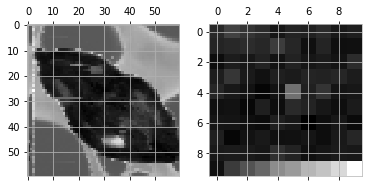

In [65]:
# ROI

xmin,xmax=45,55
ymin,ymax=7,17

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
ax2.matshow(np.average(dc.data4D,axis=(2,3))[xmin:xmax,ymin:ymax,],cmap='gray')
plt.show()

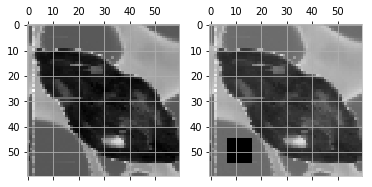

In [66]:
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
im = np.average(dc.data4D,axis=(2,3))
im[xmin:xmax,ymin:ymax] = 0
ax2.matshow(im,cmap='gray')
plt.show()

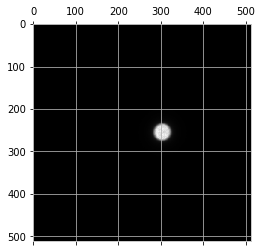

In [67]:
# Average DP, unshifted

DP_ave_unshifted = np.average(dc.data4D[xmin:xmax,ymin:ymax],axis=(0,1))

fig,ax=plt.subplots()
ax.matshow(DP_ave_unshifted,cmap='gray')
plt.show()

In [68]:
def get_shift(im1,im2):
    cc = np.fft.ifft2(np.fft.fft2(im1)*np.conj(np.fft.fft2(im2)))
    xshift,yshift = np.unravel_index(np.argmax(cc),dc.data4D.shape[2:4])
    return xshift,yshift

def get_shifted_im(im,xshift,yshift):
    nx,ny = np.shape(im)
    rxT,ryT = np.meshgrid(np.arange(nx),np.arange(ny))
    rx,ry = rxT.T,ryT.T
    nx,ny = float(nx),float(ny)
    
    w = -np.exp(-(2j*np.pi)*( (xshift*rx)/nx + (yshift*ry)/ny ))
    shifted_im = np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(im))*w)))
    return shifted_im

In [144]:
np.fft.ifft2?

In [142]:
a=np.ones((4,4))
np.fft.fft2(a)

array([[16.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [69]:
# Get average shifted diffraction pattern

ref_DP = dc.data4D[xmin,ymin,:,:]

for n in range(1,(xmax-xmin)*(ymax-ymin)):
    i = xmin + n%(xmax-xmin)
    j = ymin + int(n/(xmax-xmin))
    curr_DP = dc.data4D[i,j,:,:]
    
    xshift,yshift = get_shift(ref_DP, curr_DP)
    curr_DP_shifted = get_shifted_im(curr_DP,xshift,yshift)
    ref_DP = ref_DP*(n-1)/n + curr_DP_shifted/n

In [77]:
def get_CoM(im):
    nx,ny=np.shape(im)
    rx,ry = np.meshgrid(np.arange(nx),np.arange(ny))
    tot_intens = np.sum(im)
    xCoM = np.sum(rx*im)/tot_intens
    yCoM = np.sum(ry*im)/tot_intens
    return xCoM,yCoM

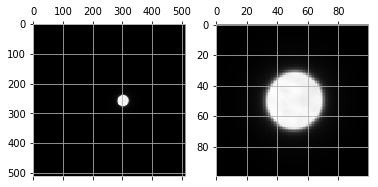

In [83]:
# Get (initial) center of mass
# Show shifted, averaged DP

xCoM_init,yCoM_init = get_CoM(ref_DP)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP,cmap='gray')
ax2.matshow(ref_DP[int(yCoM_init)-50:int(yCoM_init)+50,int(xCoM_init)-50:int(xCoM_init)+50])
plt.show()

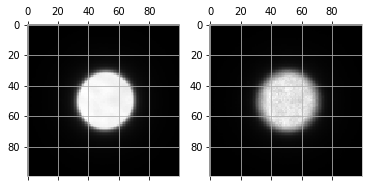

In [86]:
# Compare shifted to unshifted ave DPs

xCoM_unshifted,yCoM_unshifted = get_CoM(DP_ave_unshifted)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP[int(yCoM_init)-50:int(yCoM_init)+50,int(xCoM_init)-50:int(xCoM_init)+50])
ax2.matshow(DP_ave_unshifted[int(yCoM_unshifted)-50:int(yCoM_unshifted)+50,int(xCoM_unshifted)-50:int(xCoM_unshifted)+50])
plt.show()

In [93]:
# Mask probe outside of central disk

mask_thresh = 0.2
mask_expansion = 12

rx,ry = np.meshgrid(dc.data4D.shape[1],dc.data4D.shape[0])
mask = ref_DP > np.max(ref_DP)*mask_thresh
mask = binary_dilation(mask,iterations=mask_expansion)

#maskDist = 0.5 + 0.5*erf(maskShift + (bwdist(~maskRound) - bwdist(bwmorph(maskRound,'dilate',1))) / (0.5*maskWidth));

probe_template = ref_DP*mask

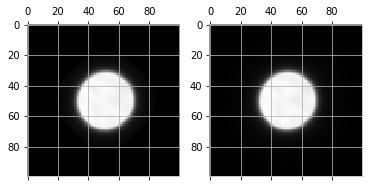

Mask alters CoM by 0.31014000886091364 pixels.


In [94]:
# Get CoM
# Compare to CoM without mask

xCoM,yCoM = get_CoM(probe_template)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template[int(yCoM)-50:int(yCoM)+50,int(xCoM)-50:int(xCoM)+50])
ax2.matshow(ref_DP[int(yCoM_init)-50:int(yCoM_init)+50,int(xCoM_init)-50:int(xCoM_init)+50])
plt.show()

print("Mask alters CoM by {} pixels.".format(np.sqrt((yCoM-yCoM_init)**2+(xCoM-xCoM_init)**2)))

In [98]:
# Get probe size

r2 = (rx-xCoM)**2 + (ry-yCoM)**2
rstd = np.sum(r2*probe_template*mask) / np.sum(probe_template)

In [133]:
# Normalize probe to one
# Subtract off gaussian, to yield a kernel which integrates to zero
sigma_probe_scale = 5

probe_template_norm = probe_template/np.sum(probe_template)
subtr_gaussian = probe_template_norm - np.exp(-r2 / (2*rstd*sigma_probe_scale**2))
subtr_gaussian = subtr_gaussian/np.sum(subtr_gaussian)
probe_kernel = probe_template_norm - subtr_gaussian

print("Probe kernel sums to {}.".format(np.sum(probe_kernel)))

Probe kernel sums to -6.106226635438361e-16.


In [134]:
# Shift probe kernel to center, then to corners
probe_kernel = get_shifted_im(probe_kernel,(xCoM-dc.data4D.shape[2]/2),(yCoM-dc.data4D.shape[3]/2))
#probe_kernel = np.fft.fftshift(probe_kernel)

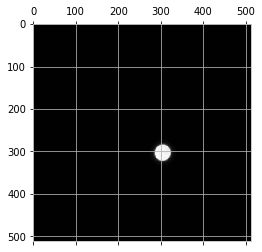

In [135]:
fig,ax=plt.subplots()
ax.matshow(probe_kernel,cmap='gray')
plt.show()

In [119]:
xCoM

300.7663129805576

In [120]:
yCoM

259.24117011726486